In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as pf
from glob import glob
from astropy import units as u
from scipy import optimize
from astropy.cosmology import WMAP9 as cosmo
import os
from scipy.integrate import quad
from astropy.convolution import convolve
import time
from scipy.stats import norm
from pymc3.math import erf
import scipy
import linmix

import warnings
warnings.filterwarnings("ignore")

In [8]:
zs={"UGC12158":0.031,"CGCG023-005":0.03334,"CGCG048-051":0.027754,"NGC5185":0.024560,
  "UGC9530":.02854,"E472-G007":.03032,"CGCG063-098":.02992,"NGC2370":.01835,"E287-G40":.03087,
   "ASASSN-15fr":.033436,"LSQ12gdj":.030,"CGCG048-099":0.032,"ASASSN-14hr":0.03362,"ASASSN-14ad":.0264,
   "E154-G010":.0186,"E153-G020":0.0197,"LSQ13ry":.0299,"NGC7580":.0148,'id11':0.05574 }

Avs={"UGC12158":0.151,"CGCG023-005":0.262,"CGCG048-051":0.124,"NGC5185":0.067,"UGC9530":.077,
    "E472-G007":0.064,"CGCG063-098":0.134,"NGC2370":0.166,"E287-G40":.078,
    "ASASSN-15fr":.104,"LSQ12gdj":0.145,"CGCG048-099":.143,"ASASSN-14hr":.041,"ASASSN-14ad":.050,"E154-G010":.082,
    "E153-G020":.073,"LSQ13ry":0.130,"NGC7580":.125,'id11':.301}

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00','deeppink','k']

gals=["E287-G40","CGCG023-005","CGCG048-099","NGC5185","NGC2370","UGC9530","ASASSN-15fr","ASASSN-14hr",
      "LSQ13ry","E153-G020"]

In [15]:
def get_sigma_i_kinematics(w):
    #input wavelength in angstroms and the instrumental resolution in km/s from the kinematics paper measurements
    a,b,c=np.loadtxt("muse_res_kinematics.txt")
    fwhm=(a * w**2) + (b*w) + c #Angstroms
    sig=fwhm/(2*np.sqrt(2*np.log(2))) #Angstroms
    sigma_i = sig * (3e5) / w #km/s
    
    return sigma_i #km/s

def get_sigma_i_calibration(w):
    #input wavlength in angstroms and get the instrumental resoluiton in km/s from the LMS calibration file
    a,b,c,d=np.loadtxt("muse_res_calibration.txt")
    fwhm=(a*w**3)+(b*w**2)+(c*w)+d #Angstroms
    sig=fwhm/(2*np.sqrt(2*np.log(2))) #Angstroms
    sigma_i=sig*(3e5) / w #km/s
    
    return sigma_i #km/s

def get_sigma_i_manual(w):
    #input wavelength in angstroms and get the manual + header shifted instrumental resolution in km/s
    m,b=np.loadtxt("muse_res_manual.txt")
    
    R=m*(w/10) + b
    
    delta=236.07 #shift from header value
    
    R+=delta
    
    sigma_i=3e5/R/(2*np.sqrt(2*np.log(2))) #km/s

    return sigma_i #km/s

In [16]:
def likelihood(x,logL,logdisp,av,v_r,FOIII,c,line,gal,resolution,plot_version=False):
    z=zs[gal] #get galaxy's redshift
    DL=float(cosmo.luminosity_distance(z).to(u.cm)/u.cm) #get galaxy's distance
    lines={"HB":4861.35,"OIII":5006.84,"HA":6562.79} #air wavelengths in angstroms of emission lines
    
    #intrinsic luminosity and velocity dispersion
    L=10**logL #Luminosity in erg/s
    disp=10**logdisp #intrinsic velocity dispersion in km/s
    
    #extinction corrected flux of Hbeta and Halpha
    FHB_corr=L/(4*np.pi*DL**2) #extinction corrected flux of Hbeta in erg/s/cm2
    FHA_corr=FHB_corr*2.86 #extinction corrected flux of Halpha in erg/s/cm2 (assuming case B)
    
    #extinction correction parameters from Gordon extinction law
    Rv=2.77 #Rv from Gordon extinction law
    kHB=3.33 #kappa from Gordon extinction law
    kHA=2.22
    
    #"Observed"/reddened fluxes of Hbeta and Halpha
    FHB=FHB_corr/(10**(.4*av*kHB/Rv)) #observed flux of Hbeta in erg/s/cm2
    FHA=FHA_corr/(10**(.4*av*kHA/Rv)) #observed flux of Halpha in erg/s/cm2
    
    #Observed emission line center given galaxy redshift (z) + line of sight velocity (v_r)
    x0=(1+z)*lines[line]*(1+(v_r/3e5)) #Angstroms
    
    #get instrumental resolution at line center from given method
    sigma_i=0 #km/s
    if resolution=='calibration': #getting sigma_i from LMS calibration file
        sigma_i+=get_sigma_i_calibration(x0)
    elif resolution=="kinematics": #getting sigma_i from Kinematics paper
        sigma_i+=get_sigma_i_kinematics(x0)
    elif resolution=="manual": #gettting sigma_i from manual + header shift
        sigma_i+=get_sigma_i_manual(x0)
    
    #get fine structure and temperature broadening for specific line, specify flux
    sigma_fs=0 #km/s
    sigma_T=0 #km/s
    F=0 #erg/s/cm2
    
    if line=="HA":
        sigma_fs+=np.sqrt(10.233)
        sigma_T+=9.1#km/s
        F+=FHA
    elif line=="HB":
        sigma_fs+=np.sqrt(5.767)
        sigma_T+=9.1
        F+=FHB
    elif line=="OIII":
        sigma_fs+=0
        sigma_T+=2.3
        F+=FOIII
    
    #get observed sigma in Angstroms by adding all components in quadrature
    sig=np.sqrt(disp**2 + sigma_i**2 + sigma_fs**2+sigma_T**2)*x0/3e5
    
    #get normalization of gaussian profile
    A=F/(np.sqrt(2*np.pi))/np.abs(sig)
    
    #perform integration to get average flux density over pixel width (1.25 Angstroms for MUSE)
    width=1.25
    left=x-(1.25/2.)
    right=x+(1.25/2.)
    
    if plot_version ==False:
        #version for fitting process which uses pymc3's erf
        integrated=A*sig*np.sqrt(np.pi/2) *(erf((x0-left)/(np.sqrt(2)*sig)) - erf((x0-right)/(np.sqrt(2)*sig)))
    elif plot_version ==True:
        #version for plotting/simple calculate which uses scipy's erf
        integrated=A*sig*np.sqrt(np.pi/2) *(scipy.special.erf((x0-left)/(np.sqrt(2)*sig)) - scipy.special.erf((x0-right)/(np.sqrt(2)*sig)))
    
    #divide by pixel width to get flux density and then add continuum value
    integrated_flux=integrated/width + c #flux density in erg/s/cm2/A

    return integrated_flux #erg/s/cm2/A

In [17]:
def get_trace(gal,hid,resolution):
    fname=gal+"/traces"+"_"+resolution+"/"+"tr_"+str(hid)+".txt"
    x=np.loadtxt(fname,dtype=str,delimiter='}')

    pars=[]
    
    names=x[0][0].split(", '")

    for i in range(len(names)):
        if 'interval' not in names[i]:
            pars.append(names[i].split(":")[0].replace("'",""))

    tr={}

    for par in pars:
        pts=[]
        for i in range(0,len(names)):
            if par in names[i] and 'interval' not in names[i]:
                ind = i
        for j in range(len(x)):
            vals=x[j][0].split(", '")
            val=vals[ind].split(":")[1]
            num=float(val.replace("]","").replace(")","").replace("}","").replace("array","").replace("(","").replace("[","").replace(",",""))
            pts.append(num)
        tr[par]=pts

    return tr

In [20]:
def plot_mcmc(gal,hid,resolution,show=True,save=False):
    z=zs[gal]
    
    tr=get_trace(gal,hid,resolution)
    
    mu=8
    wav,spec,noise=np.loadtxt(gal+"/spectra"+"_"+str(mu)+"/"+str(hid)+"_spectrum.txt")
    
    size=12
    
    #get H-beta wavelength
    HB_rest=4861.35
    HB_obs=HB_rest*(1+z)
    HB_obs_ind=np.argmin(np.abs(HB_obs-wav))
    HBleft=HB_obs_ind-size
    HBright=HB_obs_ind+size
    
    xHB=wav[HBleft:HBright+1]
    yHB=spec[HBleft:HBright+1]
    nHB=noise[HBleft:HBright+1]
    
    #get H-alpha wavelength
    HA_rest=6562.79
    HA_obs=HA_rest*(1+z)
    HA_obs_ind=np.argmin(np.abs(HA_obs-wav))
    HAleft=HA_obs_ind-size
    HAright=HA_obs_ind+size
    
    xHA=wav[HAleft:HAright+1]
    yHA=spec[HAleft:HAright+1]
    nHA=noise[HAleft:HAright+1]
    
    #get OIII wavelength
    OIII_rest=5006.84
    OIII_obs=OIII_rest*(1+z)
    OIII_obs_ind=np.argmin(np.abs(OIII_obs-wav))
    OIIIleft=OIII_obs_ind-size
    OIIIright=OIII_obs_ind+size
    
    xOIII=wav[OIIIleft:OIIIright+1]
    yOIII=spec[OIIIleft:OIIIright+1]
    nOIII=noise[OIIIleft:OIIIright+1]
    
    #get parameters from trace
    logL=np.median(tr['logL'])
    logdisp=np.median(tr['logdisp'])
    av=np.median(tr['av'])
    v_r=np.median(tr['v_r'])
    FOIII=np.median(tr["FOIII"])
    cHB=np.median(tr['cHB'])
    cOIII=np.median(tr['cOIII'])
    cHA=np.median(tr['cHA'])
    
    xplotHB=np.arange(xHB[0],xHB[-1]+.1,.1)
    yplotHB=likelihood(xplotHB,logL,logdisp,av,v_r,FOIII,cHB,"HB",gal,resolution,plot_version=True)
    ytestHB=likelihood(xHB,logL,logdisp,av,v_r,FOIII,cHB,"HB",gal,resolution,plot_version=True)

    xplotOIII=np.arange(xOIII[0],xOIII[-1]+.1,.1)
    yplotOIII=likelihood(xplotOIII,logL,logdisp,av,v_r,FOIII,cOIII,"OIII",gal,resolution,plot_version=True)
    ytestOIII=likelihood(xOIII,logL,logdisp,av,v_r,FOIII,cOIII,"OIII",gal,resolution,plot_version=True)
    
    xplotHA=np.arange(xHA[0],xHA[-1]+.1,.1)
    yplotHA=likelihood(xplotHA,logL,logdisp,av,v_r,FOIII,cHA,"HA",gal,resolution,plot_version=True)
    ytestHA=likelihood(xHA,logL,logdisp,av,v_r,FOIII,cHA,"HA",gal,resolution,plot_version=True)
    
    def get_r2(data,model):
    
        residuals = data- model
        ss_res= np.sum(residuals**2)
        ss_tot = np.sum((data-np.mean(data))**2)
        r2 = 1 - (ss_res / ss_tot)
        
        return r2
    
    r2HB=get_r2(yHB,ytestHB)
    r2OIII=get_r2(yOIII,ytestOIII)
    r2HA=get_r2(yHA,ytestHA)

    if show:
    
        fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4),sharey=True,constrained_layout=True)

        ax1.errorbar(xHB,yHB,nHB,fmt='ko',capsize=5)
        ax2.errorbar(xOIII,yOIII,nOIII,fmt='ko',capsize=5)
        ax3.errorbar(xHA,yHA,nHA,fmt='ko',capsize=5)

        ax1.plot(xplotHB,yplotHB,ls='--',color='deeppink',label=r"$R^2=$"+"%.2f"%r2HB)
        ax2.plot(xplotOIII,yplotOIII,ls='--',color='deeppink',label=r"$R^2=$"+"%.2f"%r2OIII)
        ax3.plot(xplotHA,yplotHA,ls='--',color='deeppink',label=r"$R^2=$"+"%.2f"%r2HA)

        ax1.tick_params(labelsize=12)
        ax2.tick_params(labelsize=12)
        ax3.tick_params(labelsize=12)

        ax1.set_xlabel("Wavelength (A)",fontsize=14)
        ax2.set_xlabel("Wavelength (A)",fontsize=14)
        ax3.set_xlabel("Wavelength (A)",fontsize=14)

        ax1.set_ylabel("Flux Density (erg/s/cm2/A)",fontsize=14)

        ax1.set_title(gal+" "+str(hid)+" "+"H"+r"$\beta$",fontsize=14)
        ax2.set_title(gal+" "+str(hid)+" [O III]",fontsize=14)
        ax3.set_title(gal+" "+str(hid)+" "+"H"+r"$\alpha$",fontsize=14)

        ax1.text(.6,.9,r"$\log(\sigma)$"+" = "+"%.2f"%logdisp,fontsize=14,horizontalalignment='left', verticalalignment='center', transform=ax1.transAxes)
        ax1.text(.6,.8,r"$\log(L)$"+" = "+"%.2f"%logL,fontsize=14,horizontalalignment='left', verticalalignment='center', transform=ax1.transAxes)
        
        ax1.legend(loc=2,fontsize=12)
        ax2.legend(loc=2,fontsize=12)
        ax3.legend(loc=2,fontsize=12)

        if save:
            if len(glob(gal+"/profiles*"))==0:
                os.mkdir(gal+"/profiles")
            plt.savefig(gal+"/profiles/"+str(hid)+".pdf")
        
    return r2HB,r2OIII,r2HA

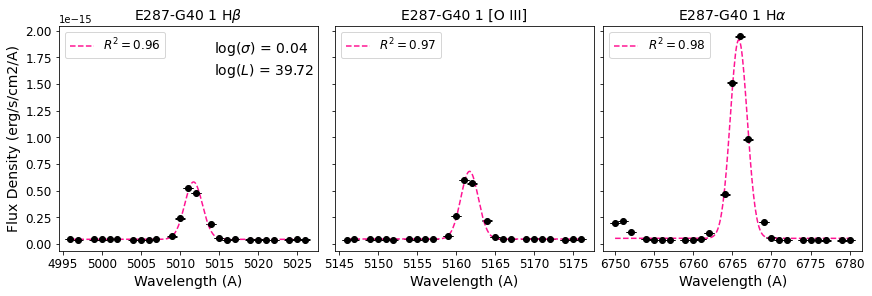

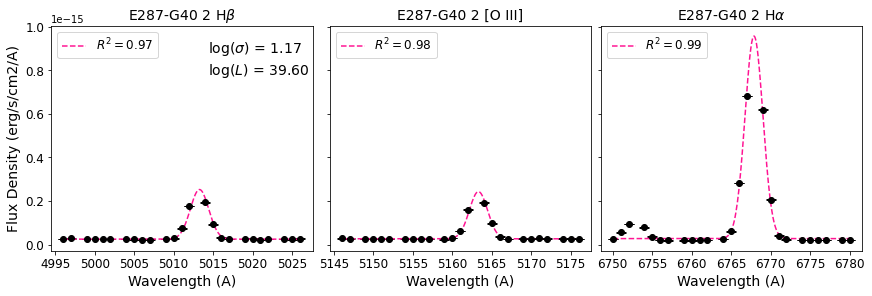

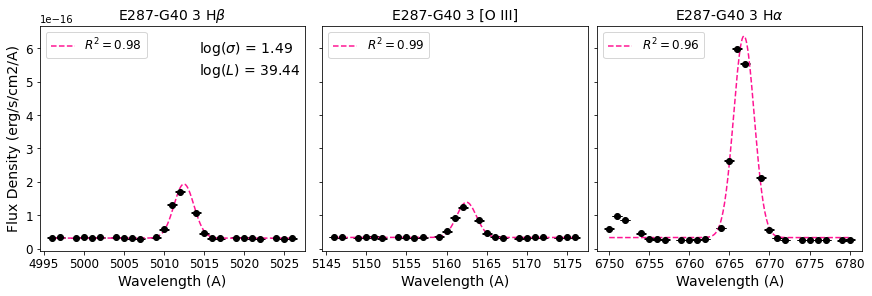

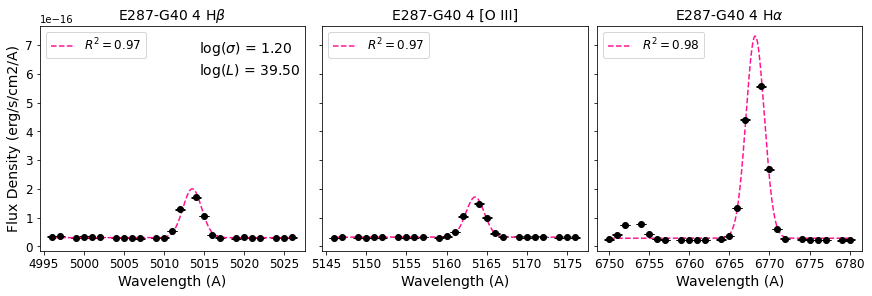

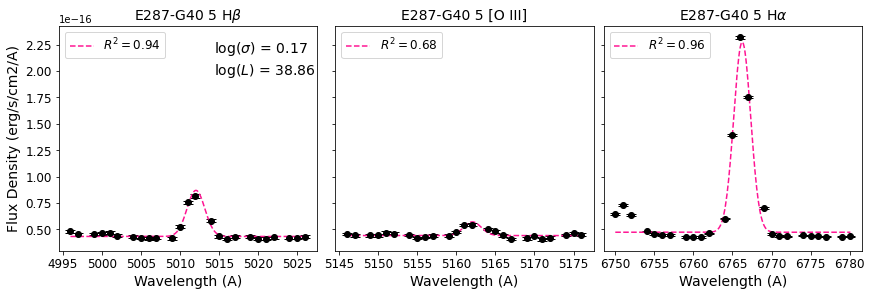

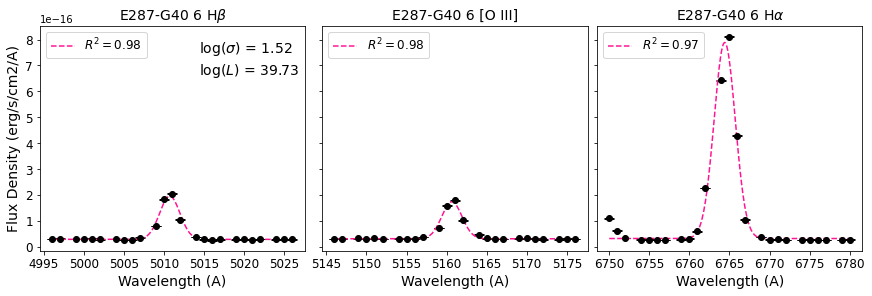

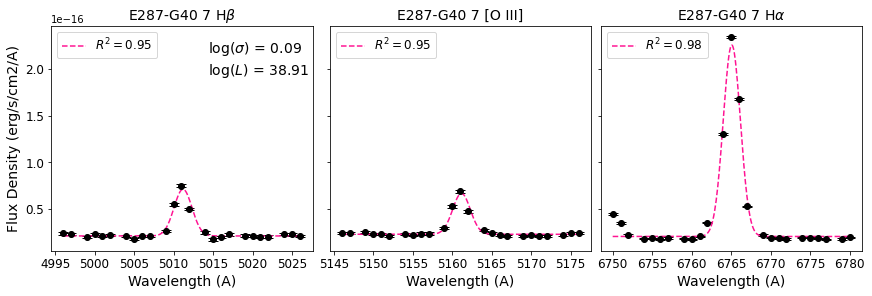

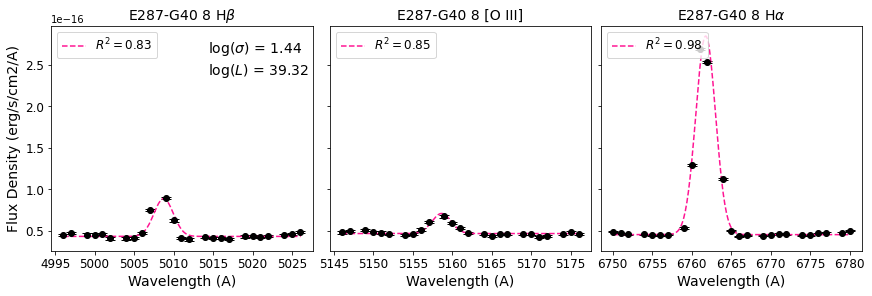

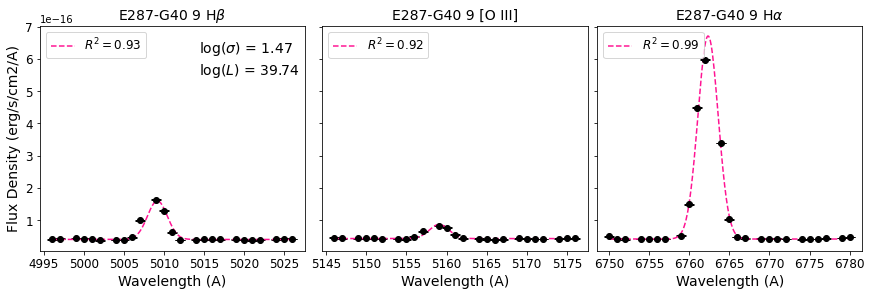

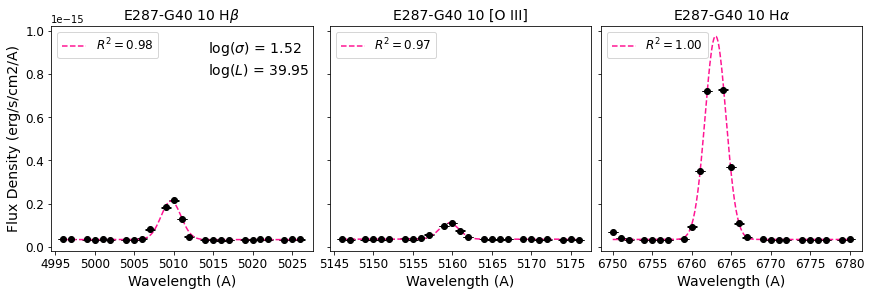

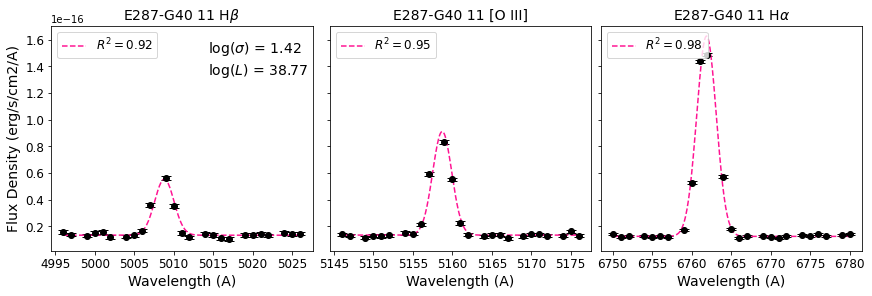

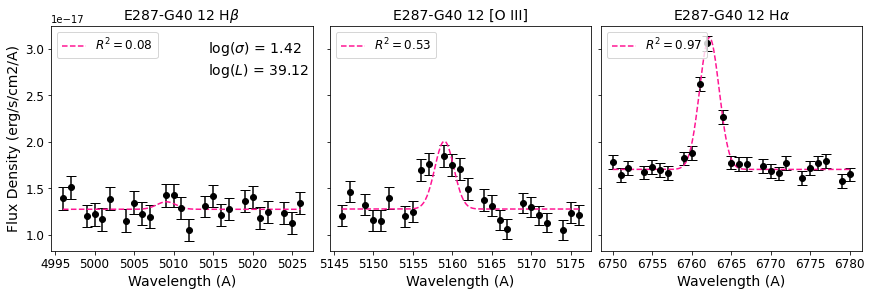

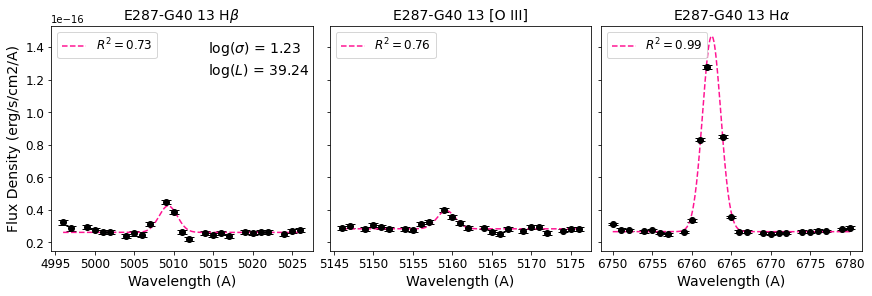

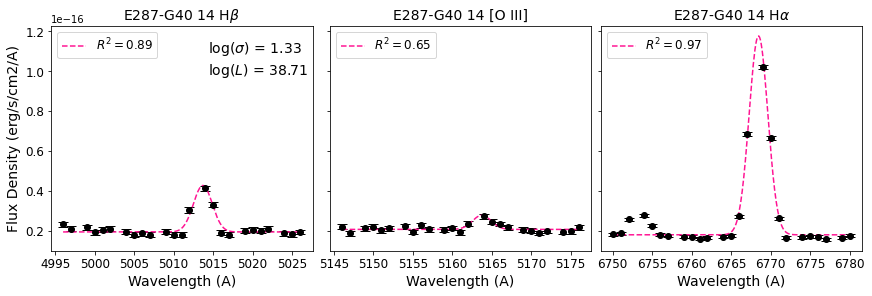

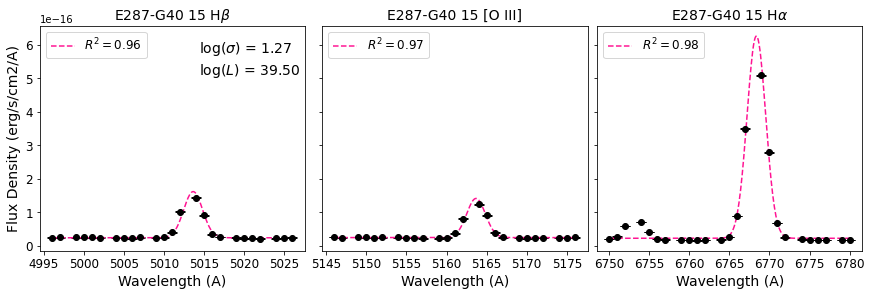

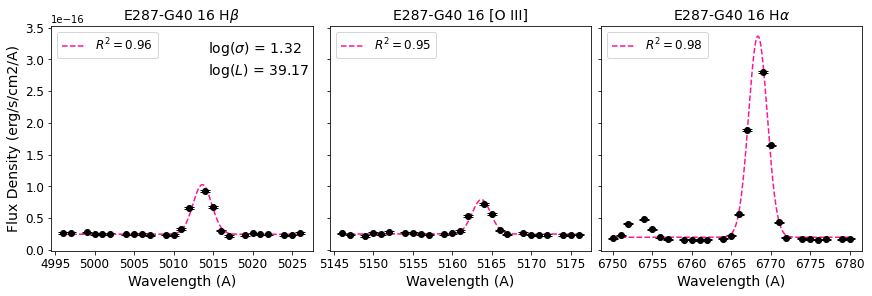

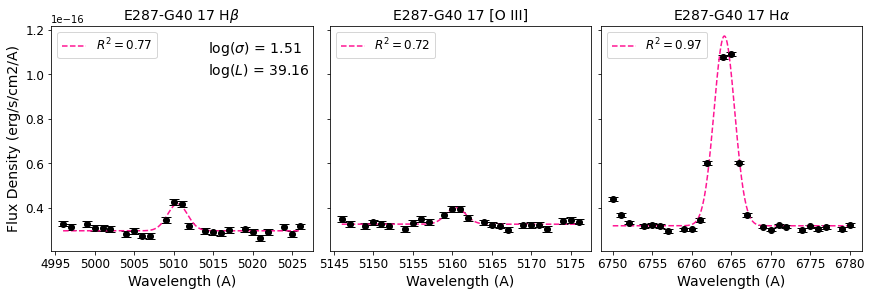

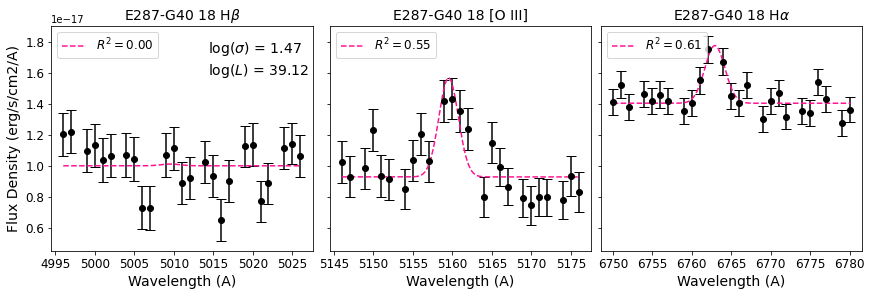

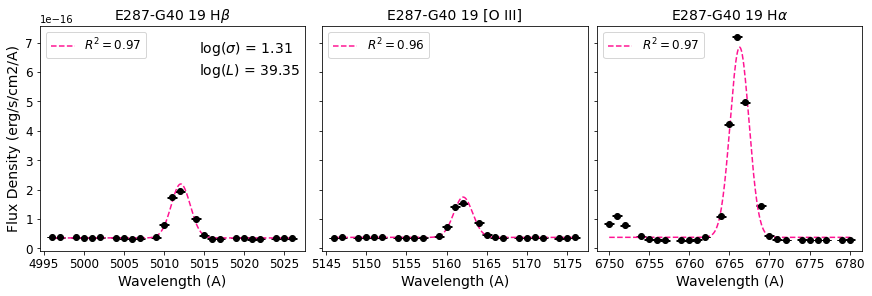

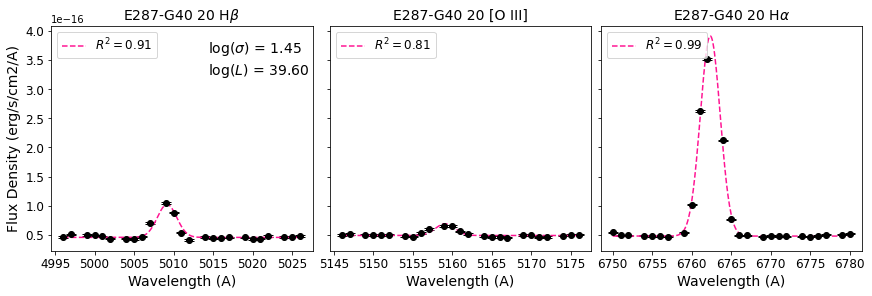

In [39]:
for hid in range(1,21):
    plot_mcmc("E287-G40",hid,"manual")

In [40]:
def get_L_sigma(gal,resolution,small=False,show=False):
    
    gal_coords=np.loadtxt(gal+"/regions.reg",dtype=str,skiprows=3)
    sigs=[]
    dsigs=[]
    Ls=[]
    dLs=[]
    for hid in range(1,len(gal_coords)+1):
        
        tr=get_trace(gal,hid,resolution)
        sigma=[np.median(tr['logdisp']),np.std(tr['logdisp'])]
        L=[np.median(tr['logL']),np.std(tr['logL'])]
        r2HB,r2OIII,r2HA=plot_mcmc(gal,hid,resolution,show)

        if sigma[0]>np.log10(13) and sigma[0] < np.log10(65) and L[1]<1 and r2HB>.5 and r2OIII>.5 and r2HA>.5 :
            sigs.append(sigma[0])
            Ls.append(L[0])
            dsigs.append(sigma[1])
            dLs.append(L[1])
            
    return sigs,dsigs,Ls,dLs

In [41]:
def plot_L_sigma(gals,resolution,small=False):
    mu=8
    
    ch_data=np.loadtxt("../chavez_lsig.csv")

    sigs_ch=ch_data[:,0]
    ls_ch=ch_data[:,1]

    xplot=np.arange(1.0,1.8,.01)
    yplot=33.25+(4.97*xplot)
    
    diffs=[]
    
    for i in range(len(sigs_ch)):
        sig_measured=sigs_ch[i]
        L_measured=ls_ch[i]
        L_exp=sig_measured*4.97 + 33.25
        diffs.append((L_exp-L_measured)**2)
        
    rms=np.sqrt(sum(diffs)/len(diffs))
    #print("Chavez rms = "+"%.3f"%rms)

    plt.figure(figsize=(9,9))
    plt.xlabel(r"$\log(\sigma)$"+" "+"[km/s]",fontsize=14)
    plt.ylabel(r"$\log(L_{H\beta})$"+" [erg/s]",fontsize=14)
    plt.xlim(1.1,1.75)
    plt.ylim(38,43)
    
    D_sp=1780 #angular diameter distance to Sp1149 (=1780Mpc)
    theta=0.7/206265 #0.7 arcsec-wide slit (spectral axis) in radians
    physical=D_sp * np.sin(theta) / np.sqrt(mu) * 1000#physical extraction size in kpc for Sp1149 (in source plane)

    #plt.scatter(sigs_ch,ls_ch,color='k',label="Chavez et al. (2012) HII Regions")
    
    
    all_sigs=[]
    d_sigs=[]
    all_Ls=[]
    d_Ls=[]

    for i,gal in enumerate(gals):
        print(gal)
        if i<len(CB_color_cycle):
            color=CB_color_cycle[i]
            symbol='o'
            size=50
        else:
            color=CB_color_cycle[i-len(CB_color_cycle)]
            symbol='*'
            size=75
            
        sigs,dsigs,Ls,dLs=get_L_sigma(gal,resolution,small)
        sigs=np.array(sigs)
        plt.errorbar(sigs,Ls,yerr=dLs,xerr=dsigs,color=color,fmt='None',capsize=5)
        plt.scatter(sigs,Ls,color=color,marker=symbol,s=size,zorder=1,label=gal)
        for i in range(len(sigs)):
            all_sigs.append(sigs[i])
            all_Ls.append(Ls[i])
            d_sigs.append(dsigs[i])
            d_Ls.append(dLs[i])

    lm = linmix.LinMix(all_sigs, all_Ls, d_sigs, d_Ls, K=2)
    lm.run_mcmc(silent=True)
    betas=[lm.chain[i]['beta'] for i in range(len(lm.chain))]
    alphas=[lm.chain[i]['alpha'] for i in range(len(lm.chain))]
    cov=np.cov(np.array([alphas,betas]),bias=True)
    sigsqr=np.median([lm.chain[i]['sigsqr'] for i in range(len(lm.chain))])
    ind84=int(.84*len(alphas))
    ind16=int(.16*len(alphas))
    
    alpha=np.median(alphas) 
    d_alpha=(np.sort(alphas)[ind84]-np.sort(alphas)[ind16])/2.
    beta=np.median(betas)
    d_beta=(np.sort(betas)[ind84]-np.sort(betas)[ind16])/2.

    
    plt.plot(xplot,(xplot*beta + alpha),zorder=1,color='blue',lw=2,label="L-"+r"$\sigma$"+" from MUSE")
    plt.plot(xplot,yplot,ls='--',lw=2,color='k',label="C12 L-"+r"$\sigma$"+" Relation")
    
    for i in range(0, len(lm.chain), 25):
        ys = (lm.chain[i]['alpha']) + (xplot * lm.chain[i]['beta']) 
        plt.plot(xplot, ys, color='r', alpha=0.02)
        
    #calculate scatter
    diffs=[]
    
    for i in range(len(all_sigs)):
        sig_measured=all_sigs[i]
        L_measured=all_Ls[i]
        L_exp=sig_measured*beta + alpha
        diffs.append((L_exp-L_measured)**2)
        
    rms=np.sqrt(sum(diffs)/len(diffs))

    plt.text(1.55,38.45,r"$\mu$"+" = "+str(mu),fontsize=14)
    plt.text(1.55,38.20,"%.2f"%physical+" kpc aperture",fontsize=14)

    plt.text(1.32,42.85,"This work:",fontsize=14,color='blue')
    plt.text(1.32,42.65,"log(L) = "+"%.2f"%alpha + "±"+"%.2f"%d_alpha+" + ("+"%.2f"%beta+"±"+"%.2f"%d_beta+")log("+r"$\sigma$"+")",color='blue',fontsize=14)
    plt.text(1.32,42.45,"rms = "+"%.3f"%rms,fontsize=14,color='blue')
    plt.text(1.46,42.45,r"$\sigma^2$"+" = "+"%.3f"%sigsqr,fontsize=14,color='blue')
    plt.text(1.32,42.20,"Chavez et al. (2012):",fontsize=14,color='k')
    plt.text(1.32,42.00,"log(L) = "+"%.2f"%33.25 + "±0.15 + ("+"%.2f"%4.97+"±0.10)log("+r"$\sigma$"+")",color='k',fontsize=14)
    plt.text(1.32,41.80,"rms = 0.236",fontsize=14,color='k')
    

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12,loc=2)
    
    plt.savefig("L_sigma_manual.png")


    return alphas,betas,cov

E287-G40
CGCG023-005
CGCG048-099
NGC5185
NGC2370
UGC9530
ASASSN-15fr
ASASSN-14hr
LSQ13ry
E153-G020


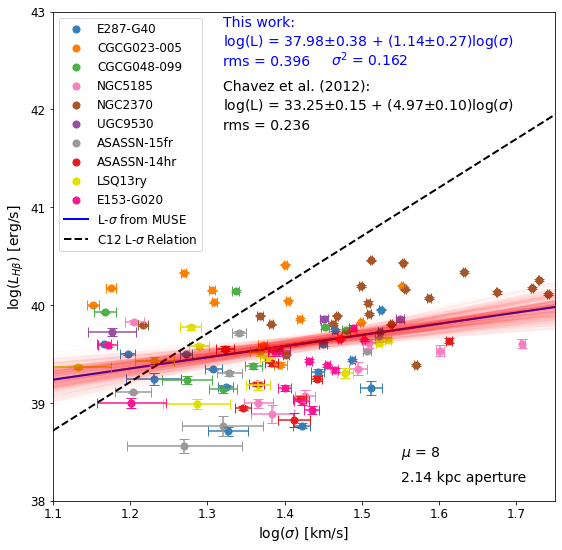

In [42]:
a,b,c=plot_L_sigma(gals,"manual")